In [1]:
import os
import json
import torch
import pickle as pkl
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import torchvision.transforms as T

In [2]:
with open('predictions.pkl', 'rb') as fp:
    preds = pkl.load(fp)

with open('hico_20160224_det/coco_class_indices_contiguous.json', 'r') as fp:
    coco_indices = json.load(fp=fp)

coco_indices = {index: label for label, index in coco_indices.items()}

In [3]:
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

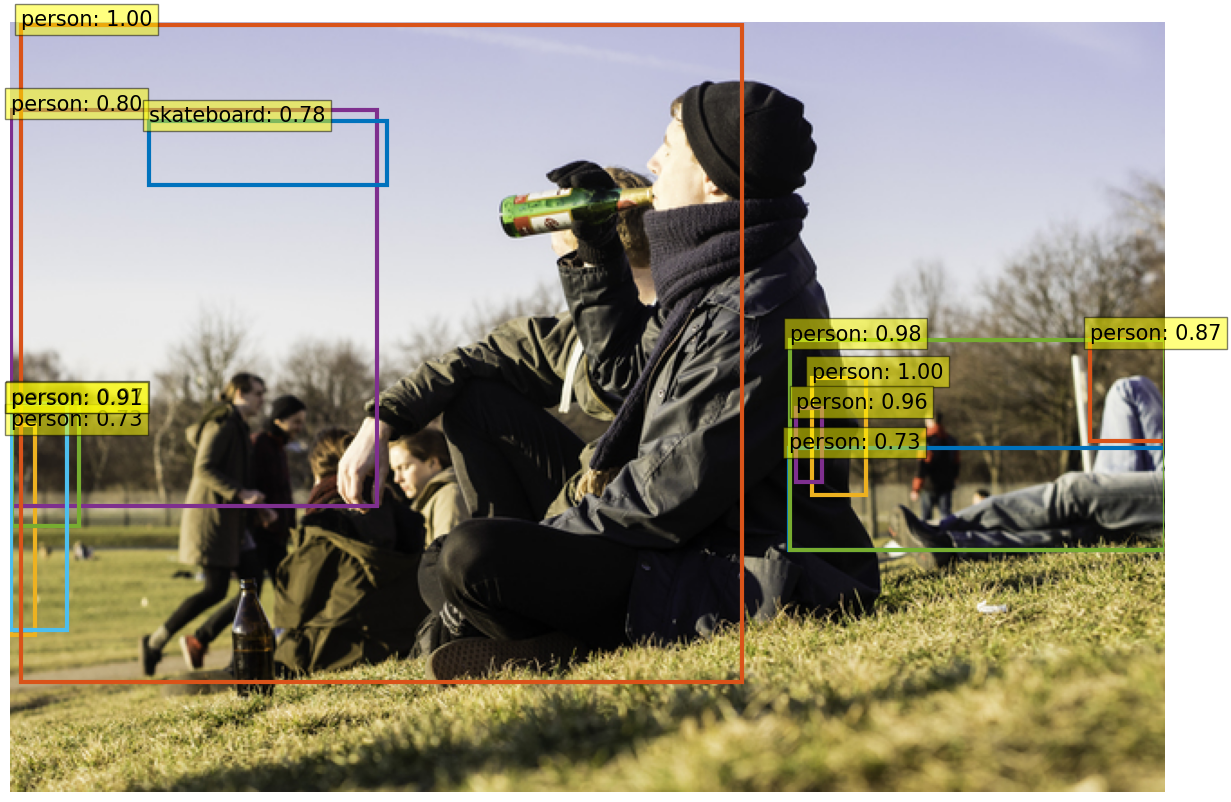

In [31]:
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

CLASSES = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
           'train', 'truck', 'boat', 'traffic light', 'fire hydrant',
           'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog',
           'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe',
           'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
           'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
           'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass',
           'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
           'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
           'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv',
           'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven',
           'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
           'teddy bear', 'hair drier', 'toothbrush']

def plot_results(img_path, outputs):
    pil_img = Image.open(img_path)
    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.7

    # convert boxes from [0; 1] to image scales
    boxes = rescale_bboxes(outputs['pred_boxes'][0, keep], pil_img.size)
    scores = probas[keep]
    
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(scores, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

image_path, outputs = preds[3]
plot_results(image_path[0], outputs)

In [32]:
image_path

['hico_20160224_det/images/train2015/HICO_train2015_00000004.jpg']